### Linear PCA with Lasso feature-selection

In [2]:
import pandas as pd
from sklearn.decomposition import KernelPCA
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
%matplotlib inline


df = pd.read_csv("data/Series3_6.15.17_padel.csv")
# Drop examples without IC50
df = df[~df.IC50.isnull()]

# Column types and counts
np.unique(df.dtypes)
len(df.columns[df.iloc[:, :].dtypes == 'O'])
len(df.columns[df.iloc[:, :].dtypes == 'int64'])
len(df.columns[df.iloc[:, :].dtypes == 'float64'])

""" Create dummies for categorical variables """

# No missing values in categorical.
sum(df[df.columns[df.iloc[:, :].dtypes == 'int64']].isnull().sum())
# Get dummy vars: filter to int type, convert to object, pass to get_dummies.
cat_vars_df = pd.get_dummies(df[df.columns[df.iloc[:, :].dtypes == 'int64']].astype('O'))

# 67 columns have missing values
sum(df[df.columns[df.iloc[:, :].dtypes == 'float64']].isnull().sum())
# Impute or remove? (for now remove any columns with nan)
cont_vars_df = df[df.columns[df.iloc[:, :].dtypes == 'float64']].dropna(axis=1)
# Drop target variable
cont_vars_df.drop("IC50", axis=1, inplace=True)

# Combine datasets
vars_df = pd.concat([cat_vars_df, cont_vars_df], axis=1)

In [3]:
# Normalize variables
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(vars_df)
x_columns = list(vars_df.columns)
y_train = y_scaler.fit_transform(df.IC50.values.reshape(-1, 1))

### Feature selection with Lasso Regression

In [4]:
# Build model
# NOTE: Gridsearch with Lasso didn't work well, "best" model output all 0's for coefficients
model = Lasso(alpha=0.01, max_iter=100000, tol=1e-5)
model.fit(x_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-05, warm_start=False)

In [5]:
# Extract coefficients
positive_coeffs = len([c for c in model.coef_ if c > 0])
neg_coeffs = len([c for c in model.coef_ if c < 0])
# Negative are selected as predictive indicators
pred_indicators = [f for f, c in zip(x_columns, model.coef_) if c < 0]
print("%s predictive indicators" % len(pred_indicators))

71 predictive indicators


### PCA with selected features

In [6]:
# Manually separate color map to focus on effective compounds
# If less 10 make zero, target -.5, else 1
# TODO we could try different values here
def create_map(x):
    if x < 1:
        return -.5
    elif x < 10:
        return 0
    else:
        return 1


color_map = df.IC50.apply(create_map)

In [7]:
# Build Linear Pricipal Components
pca = KernelPCA(n_components=None, kernel="linear", random_state=0, n_jobs=3)
pca_out = pca.fit_transform(vars_df.loc[:, pred_indicators])

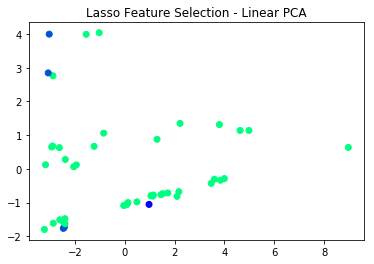

In [8]:
# Plot the pca, gradient color with IC50 (blue "potent" to green "not potent")
plt.scatter(x=pca_out[:, 0], y=pca_out[:, 1], c=color_map, cmap="winter")
plt.title("Lasso Feature Selection - Linear PCA")
plt.show()

Blue dots represent the effective compounds. This view appears more separated than PCA on entire dataset.

Next steps could be to add non-linear transformations on all data points to see if any rise up to become a predictor.
http://fmwww.bc.edu/repec/bocode/t/transint.html